# **Atajos para la adiabaticidad usando** **_counter-diabatic_** **(CD)** **_driving_**

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, qiskit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
from time import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
qiskit.__version__

'1.0.2'

Los contenidos del presente cuadernillo complementan los argumentos expuestos en la sección 3.2 del informe.

## Ejemplo sistema de 1 _spin_

Comenzaremos con un caso sencillo para ver la potencia del CD _driving_ aplicado a un sistema de un solo _spin_. Tomamos $\hat{H}(t) = (1-\lambda(t))\hat{H}_o + \lambda(t)\hat{H}_f$, para $t = \Delta(t), 2\Delta(t), \dots, T$ donde:

- $\hat{H}_o = -\sigma^x$. Su estado fundamental es el $\left|+\right\rangle$.

- $\hat{H}_f = \sigma^z$. Su estado fundamental es el $\left|1\right\rangle$.

- $\lambda(t) = \sin^2\left(\frac{\pi t}{2T}\right)$ _schedule_. Este verifica $\lambda(0) = 0$, $\lambda(T) = 1$ y que $\dot{\lambda}$ se anula en los extremos del proceso.

- $T$ es el tiempo final de la Trotterización.

- $\Delta(t)$ es el paso de la Trotterización, de modo que se realizarán $n = \frac{T}{\Delta(t)}$ iteraciones.

Realizamos el ejemplo fijando los valores pertinentes y calculamos el término del Hamiltoniano asociado al CD _driving_.

In [3]:
# Fijación de parámetros
T = 2                       # Tiempo final
delta_t = 0.1               # Paso
num_it = int(T/delta_t)     # Número de iteraciones
omega = np.pi/(2*T)

def lam_t(jt):                      # Schedule
    return np.sin(omega*jt)**2

def lam_t_diff(jt):                 # Derivada del schedule
    return omega*np.sin(2*omega*jt)

# función que calcula el término del Hamiltoniano asociado al CD driving para este caso
def termino_CD(jt):
    return ( lam_t_diff(jt) ) / (2 * ( (1-lam_t(jt))**2 + lam_t(jt)**2 ) )

A continuación, digitalizaremos el problema. En lugar de enfocarnos en los resultados finales, compararemos cuán cerca está cada digitalización (una sin CD y la otra con), del estado fundamental final: $|1\rangle$.

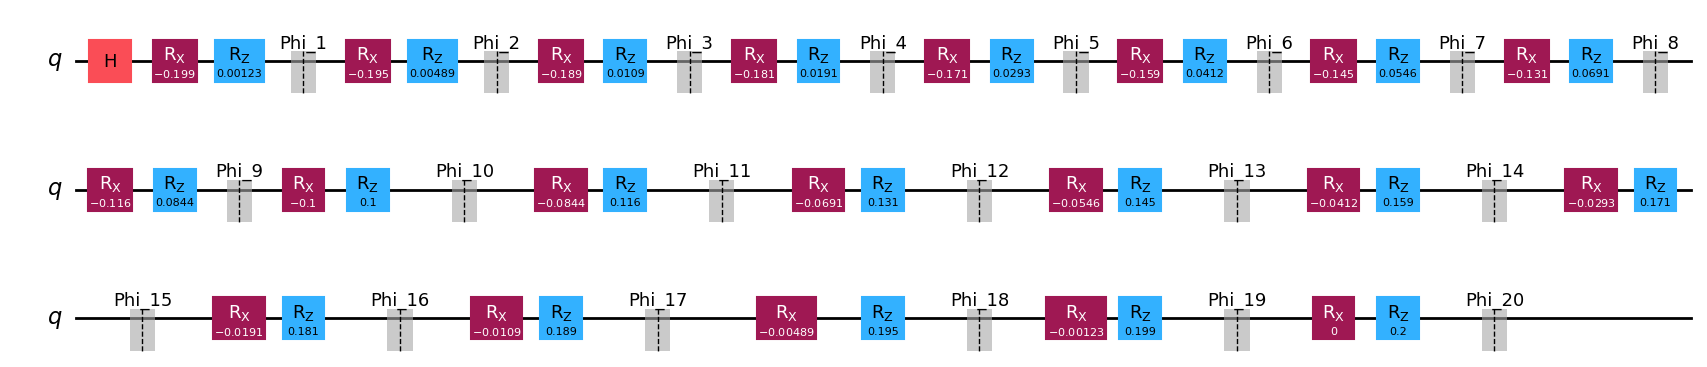

[Statevector([0.70366057+0.06972662j, 0.70357419+0.07059289j],
             dims=(2,)),
 Statevector([0.69377484+0.13622456j, 0.69309608+0.14048905j],
             dims=(2,)),
 Statevector([0.67849815+0.19735633j, 0.67601023+0.20904761j],
             dims=(2,)),
 Statevector([0.65927175+0.25132798j, 0.65281691+0.27572646j],
             dims=(2,)),
 Statevector([0.63777965+0.29675887j, 0.62410056+0.34010261j],
             dims=(2,)),
 Statevector([0.61578618+0.33269879j, 0.59044338+0.40186505j],
             dims=(2,)),
 Statevector([0.59498037+0.35859953j, 0.55234587+0.46078061j],
             dims=(2,)),
 Statevector([0.57684135+0.37425535j, 0.51016789+0.51663886j],
             dims=(2,)),
 Statevector([0.56253294+0.37973032j, 0.46409985+0.56918617j],
             dims=(2,)),
 Statevector([0.55283005+0.37529011j, 0.41416861+0.61806199j],
             dims=(2,)),
 Statevector([0.54807557+0.36135096j, 0.36027793+0.66275069j],
             dims=(2,)),
 Statevector([0.54816547+0.33845

In [4]:
# Digitalización sin CD
# Necesitamos el statevector_simulator
backend = Aer.get_backend("statevector_simulator")

circ = QuantumCircuit(1)
circ.h(0)   # Comenzamos en el estado fundamental del Hamiltoniano de origen

# Trotterización
for i in [delta_t*i for i in range(1,num_it+1)]:
    circ.rx(2*-(1-lam_t(i))*delta_t,0)
    circ.rz(2*lam_t(i)*delta_t,0)
    circ.save_statevector(label=f"Phi_{int(i/delta_t)}")

# Visualizamos el circuito
display(circ.draw("mpl"))

# Ejecutamos y guardamos los vectores de estado
job = backend.run(circ).result()
stv = [job.data(0)[f"Phi_{i}"] for i in range(1,num_it+1)]
stv

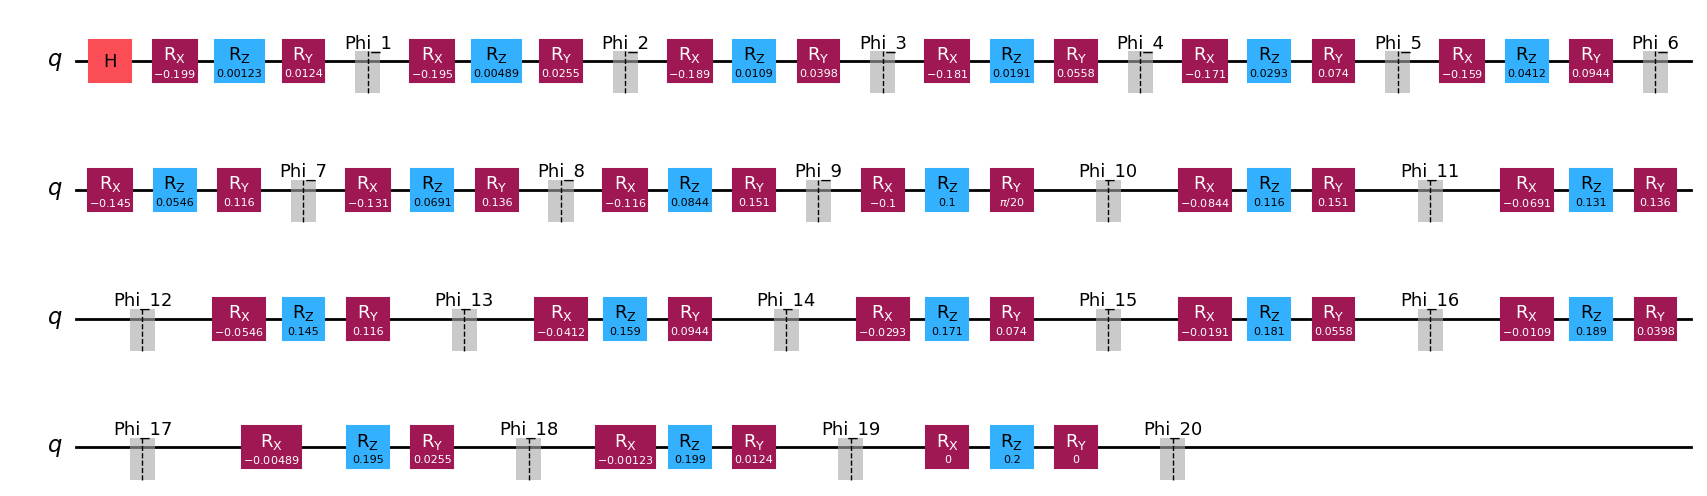

[Statevector([0.69927128+0.06928623j, 0.70793681+0.07102517j],
             dims=(2,)),
 Statevector([0.6804202 +0.13442047j, 0.70620888+0.14222699j],
             dims=(2,)),
 Statevector([0.65120625+0.19266711j, 0.70231362+0.21346051j],
             dims=(2,)),
 Statevector([0.61247147+0.24144695j, 0.69677504+0.28475709j],
             dims=(2,)),
 Statevector([0.56514019+0.27835779j, 0.6900548 +0.35631149j],
             dims=(2,)),
 Statevector([0.51019662+0.30122296j, 0.68226606+0.42834233j],
             dims=(2,)),
 Statevector([0.44885082+0.30829137j, 0.67282614+0.50079374j],
             dims=(2,)),
 Statevector([0.38294472+0.29874581j, 0.66018261+0.57294258j],
             dims=(2,)),
 Statevector([0.3154148 +0.27350347j, 0.64189241+0.64318232j],
             dims=(2,)),
 Statevector([0.25027466+0.23579431j, 0.61527621+0.70936508j],
             dims=(2,)),
 Statevector([0.1916841 +0.19069234j, 0.57836624+0.76966624j],
             dims=(2,)),
 Statevector([0.14259479+0.14356

In [5]:
# Digitalización con CD
# Necesitamos el statevector_simulator
# backend = Aer.get_backend("statevector_simulator")

circ_cd = QuantumCircuit(1)
circ_cd.h(0)    # Comenzamos en el estado fundamental del Hamiltoniano de origen

# Trotterización
for i in [delta_t*i for i in range(1,num_it+1)]:
    circ_cd.rx(2*-(1-lam_t(i))*delta_t,0)
    circ_cd.rz(2*lam_t(i)*delta_t,0)
    circ_cd.ry(2*termino_CD(i)*delta_t,0)
    circ_cd.save_statevector(label=f"Phi_{int(i/delta_t)}")

# Visualizamos el circuito
display(circ_cd.draw("mpl"))

# Ejecutamos y guardamos los vectores de estado
job = backend.run(circ_cd).result()
stv_cd = [job.data(0)[f"Phi_{i}"] for i in range(1,num_it+1)]
stv_cd

A partir de los vectores de estado podemos hallar las probabilidades que nos interesan y graficar para ambos casos.

In [6]:
def get_probabilities(svector):
    return np.power(np.abs(svector.data),2)

# Vectores con las probabilidades de colapsar a |1> tras cada iteración de la Trotterización. Comenzamos con probabilidad 0.5 por definición de |+>
res = [0.5]     # Caso sin CD
res_cd = [0.5]  # Caso con CD

for i in stv:
    res.append(get_probabilities(i)[1])

for i in stv_cd:
    res_cd.append(get_probabilities(i)[1])

# Imprimimos las probabilidades con hasta 4 decimales de precisión
print(' '.join(format(prob, '.4f') for prob in res))
print(' '.join(format(prob, '.4f') for prob in res_cd))

0.5000 0.5000 0.5001 0.5007 0.5022 0.5052 0.5101 0.5174 0.5272 0.5394 0.5535 0.5690 0.5850 0.6003 0.6139 0.6250 0.6331 0.6381 0.6404 0.6410 0.6410
0.5000 0.5062 0.5190 0.5388 0.5666 0.6031 0.6490 0.7035 0.7641 0.8257 0.8818 0.9269 0.9591 0.9795 0.9909 0.9964 0.9982 0.9982 0.9975 0.9969 0.9969


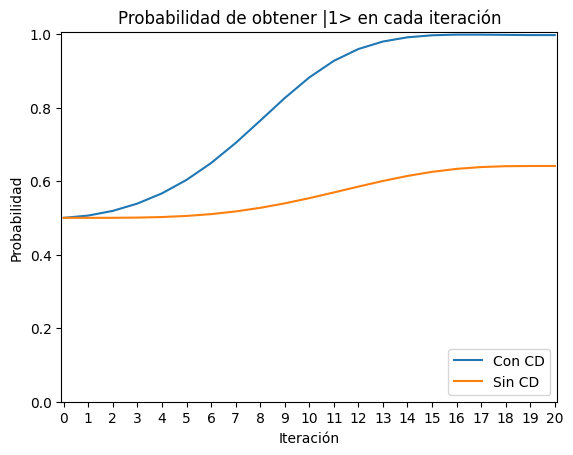

In [7]:
# Gráfica comparativa
plt.plot([i for i in range(num_it+1)],res_cd)
plt.plot([i for i in range(num_it+1)],res)

plt.xlim(-0.1,20.1)
plt.ylim(0,1.005)
plt.xticks([i for i in range(num_it+1)])
plt.xlabel("Iteración")
plt.ylabel("Probabilidad")

plt.title("Probabilidad de obtener |1> en cada iteración")
plt.legend(["Con CD","Sin CD"],loc = "lower right")

plt.show()

Como podemos observar, incluir el término CD permite alcanzar el resultado final más rápidamente.

## Aplicación del método en ejemplos ya estudiados

A continuación implementaremos en _Qiskit_ los códigos de la sección 3.2.1. Necesitaremos algunas funciones ya presentadas en $\verb|Shor_Adiabatico.ipynb|$.

In [8]:
# Función para reemplazar las potencias de las matrices de Pauli
def reemp_potencia(expr):
    '''
    Devuelve la expresión resultante de reemplazar las potencias pares de las matrices de Pauli por la identidad
    y las impares por la matriz de Pauli elevada a 1.

    expr: sympy | Hamiltoniano al que queremos añadir las propiedades de las matrices de Pauli.
    '''
    if expr.is_Pow:
        base, exp = expr.args
        if exp % 2 == 0:
            return 1
        else:
            return base
    elif expr.is_Mul or expr.is_Add:
        return expr.func(*[reemp_potencia(arg) for arg in expr.args])
    else:
        return expr
    
# Función para obtener coeficiente y variables
def coeficiente_variable(expr):
    '''
    Devuelve una lista de listas cuyos elementos son de la forma [coeficiente, variables_involucradas]. Las variables se almacenan como una lista con la
    posición del qubit (más 1), que les corresponda a dicha variable.

    expr: sympy | Hamiltoniano al que queremos añadir las propiedades de las matrices de Pauli.
    '''
    terms = expr.as_ordered_terms()
    resultado = []
    
    for term in terms:
        # Obtener el coeficiente
        coef, vars = term.as_coeff_Mul()
        
        # Obtener las variables y sus índices
        lista_vars = []
        for var in vars.free_symbols:
            if len(str(var)) >= 4:
                lista_vars.append(int(str(var)[4]))     # La posición del qubit (más 1)
        
        resultado.append((coef, sorted(lista_vars)))
    
    return resultado

def puerta_coef(coef,n_vars):
    '''
    Devuelve la puerta cuántica para la digitacización del Hamiltoniano final.

    coef: float | Coeficiente del término que forma parte del Hamiltoniano final.
    n_vars: int | Número de variables (qubits), asociados a dicho término (en nuestro caso será un máximo de 4).
    '''
    circuito = QuantumCircuit(n_vars)
    for ind in range(n_vars-1):
        circuito.cx(ind,ind+1)
    circuito.rz(2*coef,n_vars-1)
    for ind in range(n_vars-1):
        circuito.cx(n_vars-2-ind,n_vars-1-ind)
    # display(circuito.draw("mpl"))
    return circuito

### Factorización de $N = 217$

En primer lugar, recuperamos el Hamiltoniano del ejemplo.

In [9]:
import sympy as sp

# Parámetros iniciales
N = 31*7
ident = sp.symbols("I")  # Símbolo representando la matriz identidad

# Número de qubits. Asumimos longitudes de factores conocidas
nx = 2
ny = 4

# Definición de x e y usando Sum
l = sp.symbols('l', integer=True)
m = sp.symbols('m', integer=True)
sigma_z_l = sp.IndexedBase('σ^z')[l]
sigma_z_m = sp.IndexedBase('σ^z')[m]

x = sp.Sum(2**(l-ny) * (ident - sigma_z_l) / 2, (l, ny+1, nx+ny)).doit() + ident
y = sp.Sum(2**(m) * (ident - sigma_z_m) / 2, (m, 1, ny)).doit() + ident

# Expresiones de x e y
# print(x)
# print(y)

# Definición del Hamiltoniano según la proposición 3.1.5
Hamiltoniano = (N * ident - x * y) ** 2

# Expandimos y simplificamos el Hamiltoniano con las propiedades de las matrices de Pauli
# Expansión del Hamiltoniano simplificando la identidad
Hamiltoniano_expand = sp.expand(Hamiltoniano.subs(ident, 1))

# Definimos el Hamiltoniano que buscábamos
Hamiltoniano_simplificado = reemp_potencia(Hamiltoniano_expand)
print("Hamiltoniano final:\n",Hamiltoniano_simplificado)

# Extracción de coeficientes y variables
coef_vars = coeficiente_variable(Hamiltoniano_simplificado)

Hamiltoniano final:
 16*σ^z[1]*σ^z[2]*σ^z[5]*σ^z[6] - 32*σ^z[1]*σ^z[2]*σ^z[5] - 64*σ^z[1]*σ^z[2]*σ^z[6] + 84*σ^z[1]*σ^z[2] + 32*σ^z[1]*σ^z[3]*σ^z[5]*σ^z[6] - 64*σ^z[1]*σ^z[3]*σ^z[5] - 128*σ^z[1]*σ^z[3]*σ^z[6] + 168*σ^z[1]*σ^z[3] + 64*σ^z[1]*σ^z[4]*σ^z[5]*σ^z[6] - 128*σ^z[1]*σ^z[4]*σ^z[5] - 256*σ^z[1]*σ^z[4]*σ^z[6] + 336*σ^z[1]*σ^z[4] - 128*σ^z[1]*σ^z[5]*σ^z[6] - 178*σ^z[1]*σ^z[5] - 356*σ^z[1]*σ^z[6] + 1064*σ^z[1] + 64*σ^z[2]*σ^z[3]*σ^z[5]*σ^z[6] - 128*σ^z[2]*σ^z[3]*σ^z[5] - 256*σ^z[2]*σ^z[3]*σ^z[6] + 336*σ^z[2]*σ^z[3] + 128*σ^z[2]*σ^z[4]*σ^z[5]*σ^z[6] - 256*σ^z[2]*σ^z[4]*σ^z[5] - 512*σ^z[2]*σ^z[4]*σ^z[6] + 672*σ^z[2]*σ^z[4] - 256*σ^z[2]*σ^z[5]*σ^z[6] - 356*σ^z[2]*σ^z[5] - 712*σ^z[2]*σ^z[6] + 2128*σ^z[2] + 256*σ^z[3]*σ^z[4]*σ^z[5]*σ^z[6] - 512*σ^z[3]*σ^z[4]*σ^z[5] - 1024*σ^z[3]*σ^z[4]*σ^z[6] + 1344*σ^z[3]*σ^z[4] - 512*σ^z[3]*σ^z[5]*σ^z[6] - 712*σ^z[3]*σ^z[5] - 1424*σ^z[3]*σ^z[6] + 4256*σ^z[3] - 1024*σ^z[4]*σ^z[5]*σ^z[6] - 1424*σ^z[4]*σ^z[5] - 2848*σ^z[4]*σ^z[6] + 8512*σ^z[4] + 1364*σ^z[

Fijamos el _schedule_ correspondiente. Además, aprovechamos para la asignación de parámetros necesarios. Comparando con el ejemplo sin término CD, el único cambio realizado es el incremento del paso de $\Delta(t) = 0.01$ a $\Delta(t) = 0.05$. Consecuentemente, la Trotterización contará con menos iteraciones.

In [10]:
T = 10                      # Tiempo final
delta_t = 0.05              # Paso
num_it = int(T/delta_t)     # Número de iteraciones
omega = np.pi/(2*T)

# Schedule en función de la iteración en la que se encuentra la troterización
def lam_t_dig(jt):
    return np.sin(np.pi/2*np.sin(omega*jt)**2)**2

# Derivada del schedule en función de la iteración en la que se encuentra la troterización
def lam_t_dig_diff(jt):
    return omega*np.pi*np.cos(omega*jt)*np.sin(omega*jt)*np.sin(np.pi*np.sin(omega*jt)**2)

Definamos una función que calcule localmente el coeficiente CD que le corresponda al _qubit_ especificado en la iteración que se encuentre.

In [11]:
def calcula_CD_i(coef_vars, indice_i, jt):
    '''
    Devuelve el coeficiente del término CD asociado al qubit (indice_i - 1) en el momento jt de la Trotterización.

    coef_vars: list | Lista de listas de la forma dada por la aplicación de la función coeficiente_variable al Hamiltoniano estudiado.
    indice_i: int | Posición del qubit (más 1), sobre el que queremos calcular el término CD.
    jt: float | Valor temporal dado por la iteración en la que se encuentra el proceso de digitalización. Es de la forma k*delta_t
    siendo k un entero comprendido entre 1 y el número de iteraciones, y delta_t el paso de la Trotterización.
    '''
    Jz = 0      # Coeficiente de interacción a dos cuerpos
    Kz = 0      # Coeficiente de interacción a tres cuerpos
    Lz = 0      # Coeficiente de interacción a cuatro cuerpos
    hxCD = -1*(1-lam_t_dig(jt))             # Coeficiente del Hamiltoniano inicial con schedule incorporado
    hxCDdiff = -(-1)*lam_t_dig_diff(jt)     # Derivada del coeficiente del Hamiltoniano inicial con schedule incorporado

    # Calculamos todos los coeficientes restantes
    for ind in coef_vars[:-1]:
        if ind[1][0] == indice_i:
            l = len(ind[1])
            if l == 1:
                hz = lam_t_dig(jt)*ind[0]           # Coeficiente de interacción indicidual
                hzdiff = lam_t_dig_diff(jt)*ind[0]  # Derivada del coeficiente de interacción individual
            elif l == 2:
                Jz += (lam_t_dig(jt)*ind[0])**2
            elif l == 3:
                Kz += (lam_t_dig(jt)*ind[0])**2
            else:
                Lz += (lam_t_dig(jt)*ind[0])**2

    # Devolvemos el término multiplicado por la derivada del schedule
    return float(( hz*hxCDdiff - hxCD*hzdiff )/( 2*( hxCD**2 + hz**2 + 2*Jz + 3*Kz + 4*Lz ) ))*lam_t_dig_diff(jt)


Digitalicemos el problema añadiendo CD.

Tiempo de creación del circuito: 6.02715277671814
Tiempo de simulación: 0.47498083114624023


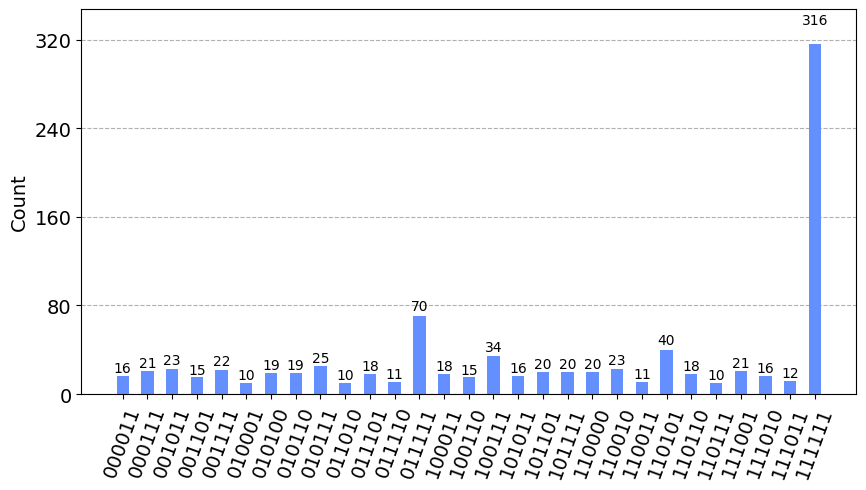

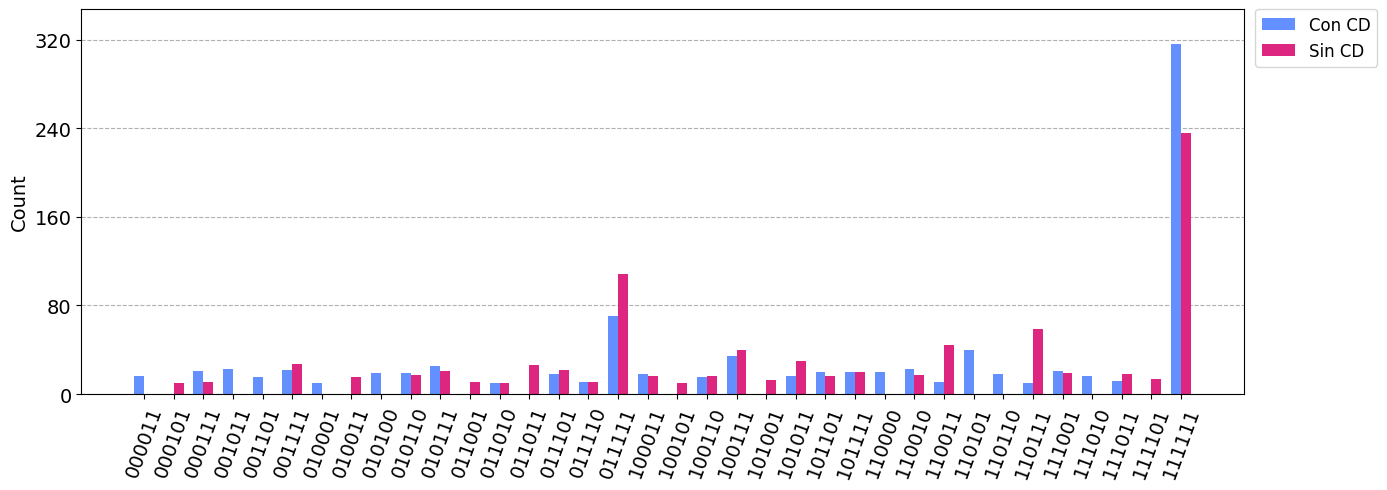

In [12]:
# Circuito para la digitalización
t0 = time()
dig_circuit_qreg = QuantumRegister(nx+ny)
dig_circuit_creg = ClassicalRegister(nx+ny)
dig_circuit = QuantumCircuit(dig_circuit_qreg,dig_circuit_creg)

# Comenzamos con el estado fundamental del Hamiltoniano inicial
dig_circuit.h(dig_circuit_qreg)

# Trotterización
for i in [delta_t*i for i in range(1,num_it+1)]:
    dig_circuit.rx(2*(1-lam_t_dig(i))*(-1)*delta_t,dig_circuit_qreg)                                                            # Factor -1 debido al coeficiente del Hamiltoniano inicial
    for coef, vars in coef_vars[:-1]:                                                                                           # No tomamos el término independiente del Hamiltoniano
        dig_circuit.append(puerta_coef(int(coef)*lam_t_dig(i)*delta_t,len(vars)),[dig_circuit_qreg[i-1] for i in vars])
    for ind in range(1,nx+ny+1):
        dig_circuit.ry(2*calcula_CD_i(coeficiente_variable(Hamiltoniano_simplificado),ind,i)*delta_t,dig_circuit_qreg[ind-1])   # Parte CD

# Mediciones
dig_circuit.measure(dig_circuit_qreg,dig_circuit_creg)
t1 = time()-t0
print("Tiempo de creación del circuito:",t1)

# Simulación en qasm_simulator
dig_circuit = dig_circuit.decompose()                   # Para evitar tiempo de traspilado tomamos el circuito descompuesto
t0 = time()
backend = Aer.get_backend("qasm_simulator")
result = backend.run(dig_circuit,shots=1000).result()
t1 = time()-t0
print("Tiempo de simulación:",t1)

# Resultados sin CD obtenidos del cuadernillo Shor_Adiabatico.ipynb
no_CD_filt_counts = {'010110': 17, '000111': 11, '100101': 10, '111011': 18, '101011': 30, '111001': 19, '101101': 16, '110011': 44, '011111': 108, '110111': 59, '111111': 236, '011011': 26, '101111': 20, '001111': 27, '100110': 16, '100111': 40, '011001': 11, '011101': 22, '100011': 16, '111101': 14, '110010': 17, '000101': 10, '011010': 10, '101001': 13, '010111': 21, '010011': 15, '011110': 11}
# Resultados con CD
filt_counts = {k:v for k,v in result.get_counts().items() if v >= 1000*0.01}
# Histograma con los resultados filtrados a aquellos superando un 1% de los shots realizados
display(plot_histogram(filt_counts,figsize=(10,5)))
# Mostramos una comparativa entre los resultados con y sin protocolo CD
display(plot_histogram([filt_counts,no_CD_filt_counts],legend=["Con CD","Sin CD"],figsize=(15,5),bar_labels=False))

Obtenemos resultados mejores e incluso mitigamos estados que antes aparecían con más frecuencia. Todo ello con menos iteraciones.

### Factorizando $N = 91$

Una vez más, necesitamos recuperar el Hamiltoniano tal y como se construyó con anterioridad.

In [13]:
# Parámetros iniciales
N = 7*13
ident = sp.symbols("I")  # Símbolo representando la matriz identidad

# Cálculo de qubits. No sabemos las longitudes de los factores, por
# lo que calculamos el número de qubits con lo visto en la teoría
if np.floor(np.sqrt(N)) % 2:  # Parte entera impar
    nx = int(np.ceil(np.log2(np.floor(np.sqrt(N)))) - 1)
else:
    nx = int(np.ceil(np.log2(np.floor(np.sqrt(N) - 1))) - 1)

ny = int(np.ceil(np.log2(np.floor(N / 3))) - 1)

# Valores de n_x y de n_y
print(f"Se tiene que n_x = {nx} y n_y = {ny}.\n")

# Definición de x e y usando Sum
l = sp.symbols('l', integer=True)
m = sp.symbols('m', integer=True)
sigma_z_l = sp.IndexedBase('σ^z')[l]
sigma_z_m = sp.IndexedBase('σ^z')[m]

x = sp.Sum(2**(l-ny) * (ident - sigma_z_l) / 2, (l, ny+1, nx+ny)).doit() + ident
y = sp.Sum(2**(m) * (ident - sigma_z_m) / 2, (m, 1, ny)).doit() + ident

# Expresiones de x e y
# print(x)
# print(y)

# Definición del Hamiltoniano según la proposición 3.1.5
Hamiltoniano = (N * ident - x * y) ** 2

# Expandimos y simplificamos el Hamiltoniano con las propiedades de las matrices de Pauli
# Expansión del Hamiltoniano simplificando la identidad
Hamiltoniano_expand = sp.expand(Hamiltoniano.subs(ident, 1))

# Definimos el Hamiltoniano que buscábamos
Hamiltoniano_simplificado = reemp_potencia(Hamiltoniano_expand)
print("Hamiltoniano final:\n",Hamiltoniano_simplificado)

# Extracción de coeficientes y variables
coef_vars = coeficiente_variable(Hamiltoniano_simplificado)

Se tiene que n_x = 3 y n_y = 4.

Hamiltoniano final:
 16*σ^z[1]*σ^z[2]*σ^z[5]*σ^z[6] + 32*σ^z[1]*σ^z[2]*σ^z[5]*σ^z[7] - 64*σ^z[1]*σ^z[2]*σ^z[5] + 64*σ^z[1]*σ^z[2]*σ^z[6]*σ^z[7] - 128*σ^z[1]*σ^z[2]*σ^z[6] - 256*σ^z[1]*σ^z[2]*σ^z[7] + 340*σ^z[1]*σ^z[2] + 32*σ^z[1]*σ^z[3]*σ^z[5]*σ^z[6] + 64*σ^z[1]*σ^z[3]*σ^z[5]*σ^z[7] - 128*σ^z[1]*σ^z[3]*σ^z[5] + 128*σ^z[1]*σ^z[3]*σ^z[6]*σ^z[7] - 256*σ^z[1]*σ^z[3]*σ^z[6] - 512*σ^z[1]*σ^z[3]*σ^z[7] + 680*σ^z[1]*σ^z[3] + 64*σ^z[1]*σ^z[4]*σ^z[5]*σ^z[6] + 128*σ^z[1]*σ^z[4]*σ^z[5]*σ^z[7] - 256*σ^z[1]*σ^z[4]*σ^z[5] + 256*σ^z[1]*σ^z[4]*σ^z[6]*σ^z[7] - 512*σ^z[1]*σ^z[4]*σ^z[6] - 1024*σ^z[1]*σ^z[4]*σ^z[7] + 1360*σ^z[1]*σ^z[4] - 128*σ^z[1]*σ^z[5]*σ^z[6] - 256*σ^z[1]*σ^z[5]*σ^z[7] + 330*σ^z[1]*σ^z[5] - 512*σ^z[1]*σ^z[6]*σ^z[7] + 660*σ^z[1]*σ^z[6] + 1320*σ^z[1]*σ^z[7] - 1264*σ^z[1] + 64*σ^z[2]*σ^z[3]*σ^z[5]*σ^z[6] + 128*σ^z[2]*σ^z[3]*σ^z[5]*σ^z[7] - 256*σ^z[2]*σ^z[3]*σ^z[5] + 256*σ^z[2]*σ^z[3]*σ^z[6]*σ^z[7] - 512*σ^z[2]*σ^z[3]*σ^z[6] - 1024*σ^z[2]*σ^z[3]*σ^z[7] + 136

En esta ocasión, digitalizaremos el problema tomando $\Delta(t) = 0.005$ en lugar de $\Delta(t) = 0.001$. Una vez más, reducimos el número de iteraciones.

Tiempo de creación del circuito: 114.3709135055542
Tiempo de simulación: 9.23347282409668


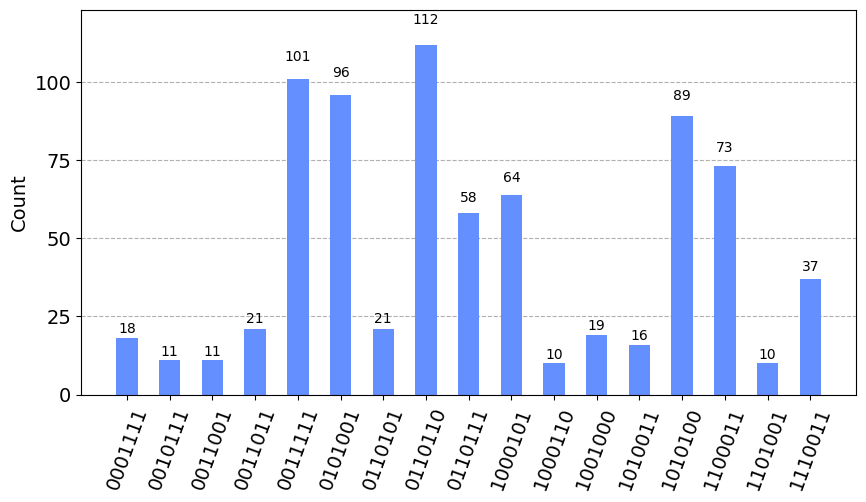

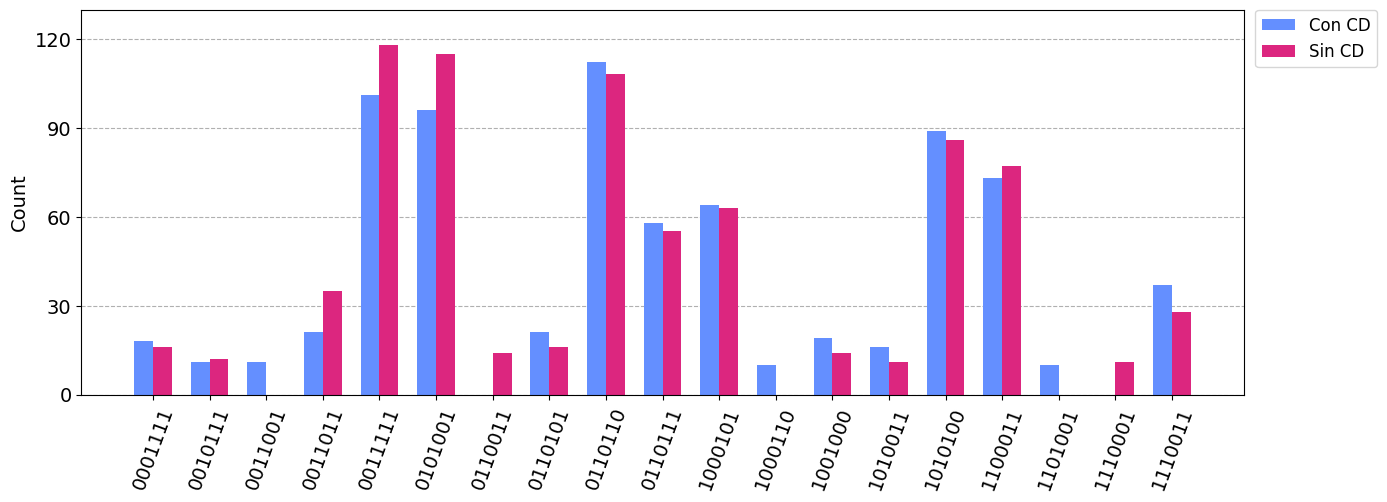

In [14]:
T = 10                      # Tiempo final
delta_t = 0.005             # Paso
num_it = int(T/delta_t)     # Número de iteraciones
omega = np.pi/(2*T)

# Circuito para la digitalización
t0 = time()
dig_circuit_qreg = QuantumRegister(nx+ny)
dig_circuit_creg = ClassicalRegister(nx+ny)
dig_circuit = QuantumCircuit(dig_circuit_qreg,dig_circuit_creg)

# Comenzamos con el estado fundamental del Hamiltoniano inicial
dig_circuit.h(dig_circuit_qreg)

# Trotterización
for i in [delta_t*i for i in range(1,num_it+1)]:
    dig_circuit.rx(2*(1-lam_t_dig(i))*(-1)*delta_t,dig_circuit_qreg)                                                            # Factor -1 debido al coeficiente del Hamiltoniano inicial
    for coef, vars in coef_vars[:-1]:                                                                                           # No tomamos el término independiente del Hamiltoniano
        dig_circuit.append(puerta_coef(int(coef)*lam_t_dig(i)*delta_t,len(vars)),[dig_circuit_qreg[i-1] for i in vars])
    for ind in range(1,nx+ny+1):
        dig_circuit.ry(2*calcula_CD_i(coeficiente_variable(Hamiltoniano_simplificado),ind,i)*delta_t,dig_circuit_qreg[ind-1])   # Parte CD

# Mediciones
dig_circuit.measure(dig_circuit_qreg,dig_circuit_creg)
t1 = time()-t0
print("Tiempo de creación del circuito:",t1)

# Simulación en qasm_simulator
dig_circuit = dig_circuit.decompose()                   # Para evitar tiempo de traspilado tomamos el circuito descompuesto
t0 = time()
backend = Aer.get_backend("qasm_simulator")
result = backend.run(dig_circuit,shots=1000).result()
t1 = time()-t0
print("Tiempo de simulación:",t1)

# Resultados sin CD obtenidos del cuadernillo Shor_Adiabatico.ipynb
no_CD_filt_counts = {'1110001': 11, '1000101': 63, '0110110': 108, '0101001': 115, '1110011': 28, '0110111': 55, '0011111': 118, '1100011': 77, '1010100': 86, '0110011': 14, '0011011': 35, '0110101': 16, '1001000': 14, '1010011': 11, '0010111': 12, '0001111': 16}
# Resultados con CD
filt_counts = {k:v for k,v in result.get_counts().items() if v >= 1000*0.01}
# Histograma con los resultados filtrados a aquellos superando un 1% de los shots realizados
display(plot_histogram(filt_counts,figsize=(10,5)))
# Mostramos una comparativa entre los resultados con y sin protocolo CD
display(plot_histogram([filt_counts,no_CD_filt_counts],legend=["Con CD","Sin CD"],figsize=(15,5),bar_labels=False))

Hemos llegado a la solución buscada. Eso sí, aunque hemos requerido de una menor cantidad de iteraciones, y menos tiempo de creación y simulación; siguen habiendo estados cuya frecuencia de aparición es notoria.